# Vorhersagemodellierung - Sommersemster 2020 (Fetti)

Aufgabenstellung in der [PDF](Vorhersagemodellierung-SoSe-2020-WMQD.pdf).

TL;DR:

1. Gesucht ist ein Schätzermodell $\hat{f}(x_{0}) = \hat{y}_{0}$
2. Zeilvariable $\hat{y}_{0}$ ist Anzahl der Klicks


## Setup environment

In [2]:
# Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# show versions
print(pd.__version__)
print(sns.__version__)

1.0.5
0.10.1


### Load datasets

In [5]:
df_train = pd.read_csv("Trainingsdaten.csv", sep=";")
df_test = pd.read_csv("Anwendungsdaten.csv", sep=";")

# Show infos
print("Trainingsdaten:\n")
print(df_train.info())

print("Testdaten:\n")
print(df_test.info())

Trainingsdaten:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   wochentag  400 non-null    int64 
 1   stunde     400 non-null    int64 
 2   likes      400 non-null    int64 
 3   typ        400 non-null    object
 4   kategorie  400 non-null    object
 5   bezahlt    400 non-null    object
 6   klicks     400 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 17.2+ KB
None
Testdaten:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   wochentag  100 non-null    int64 
 1   stunde     100 non-null    int64 
 2   likes      100 non-null    int64 
 3   typ        100 non-null    object
 4   kategorie  100 non-null    object
 5   bezahlt    100 non-null    object
dtypes: int64(3), object(3)
memory usage: 3.6

**Take-aways:**
- 500 Samples (Datenpunkte), davon 400 im Trainings- und 100 im Test-set
- Anzahl der Features (ohne Zielvariable): 5
- Davon sind 4 kathegorische Features (beachte, dass Wochentag zwar numerisch von 0 bis 6 dargestellt wird, in der praxis aber dennoch kathegorisch ist)

## EDA

###  Fist look at the target ("klicks")

Hier ist es wichtig die exploartive Datenanalyse _nur_ für die Trainingsdaten durchzuführen um so, keinen _data spillover_ aus den Testdaten zu haben. D.h. man sucht ein Modell, dass die Zusammenhänge der Trainingsdaten bzw. deren Verteilung gut darstellt und trotzdem gut auf den Testdaten prognostiziert (ohne diese jemals gesehen zu haben).

Natürlich kann man hier schummeln und sich einfach ein modell auf die testdaten zu fitten, aber ich denke das führt richtigerweise zu Punktabzug ;-)

Ich würde hier erstmal Hypothesen der Form "gibt es signifikante Unterschiede an welchen Tagen bzw. zu welcher Stunde poste ich meine Werbung" testen. Danach kann man sich ein Modell bauen, was man als Baseline verwendet.

Ich schaue mir zu erst die Verteilung der Klicks allgemein an.

In [6]:
df_train["klicks"].describe()

count      400.000000
mean      1491.325000
std       2171.087331
min         20.000000
25%        512.000000
50%        867.000000
75%       1515.250000
max      19781.000000
Name: klicks, dtype: float64

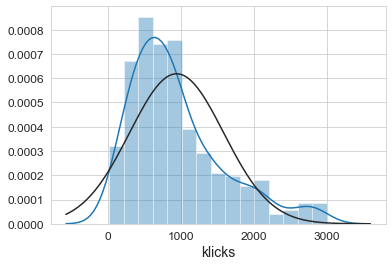

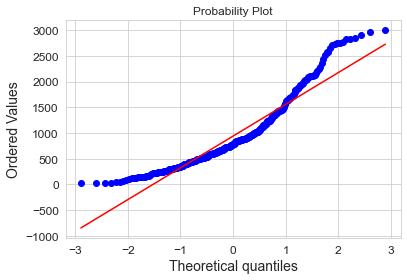

In [34]:
from scipy.stats import norm
from scipy import stats
sns.distplot(df_train['klicks'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['klicks'], plot=plt)

In [8]:
#skewness and kurtosis
print("Skewness: {:f}".format(df_train['klicks'].skew()))
print("Kurtosis: {:f}".format(df_train['klicks'].kurt()))

Skewness: 4.581947
Kurtosis: 27.355072


**Take-away:** Die Summary-Stats zeigt, dass keine Samples vorhanden sind gleich Null. Die Klicks sind sehr stark verzerrt und viele Samples haben nur kleine Klickzahlen. Der Datensatz weißt eine linksverschiebung auf. Das zeigt sich durch den starken Unterschied zwischen Mittelwert (1491 Klicks) mit einer Standardabweichung von 2171, also anderthalbmal soviel vom Mittelwert verschoben. Das liegt an Ausreissern (etwa max 19781 Klicks für einen Post).

Ich würde hier einmal einen genaueren Blick in die Daten werfen und checken, ob es sich nicht lohnt die oberen 5% abzuscheiden, weil die Daten sehr starke Verzerrung aufweisen (s.o *skewness* & *kurtorsis*).

Es fällt auch auf, dass die Klicks keiner Normalverteilung folgen. Möglich ist dann eine transformation der Daten um die Zielvariable "normal" zu machen. Manche Algorithmen funktionieren besser mit normal-verteilten Variablen.

**Note:** Ich denke die Anzahl der klicks ist keine wirklich gute Darstellung der Zielvaribale und definiere deshalb eine neue Variable **klickrate**, indem ich die Klicks in Relation zu den Likes der Seite setze (per 1000).
Diese Varibale ist vielsagender als die _reine_ Klickanzahl.

### Remove outliers

Ich würde mal die fetten Fische entfernen.

In [32]:
df_train.loc[df_train["klicks"] < 5000].describe()

,wochentag,stunde,likes,klicks,klickrate
count,360.000000,360.000000,360.000000,360.000000,360.000000
mean,4.186111,7.736111,123873.808333,940.169444,7.965973
std,1.990598,4.352162,15858.820734,646.163597,5.901677
min,1.000000,1.000000,81369.000000,20.000000,0.144492
25%,3.000000,3.000000,116092.750000,486.750000,3.597628
50%,4.000000,9.000000,130791.500000,786.500000,6.684135
75%,6.000000,11.000000,136392.000000,1236.500000,10.274482
max,7.000000,23.000000,139442.000000,2998.000000,31.549879


In [33]:
df_train = df_train.loc[df_train["klicks"] < 5000]

In [13]:
df_train["klickrate"] = df_train["klicks"] / df_train["likes"] * 1000

In [14]:
df_train["klickrate"].describe()

count    400.000000
mean      12.677471
std       19.003735
min        0.144492
25%        3.872033
50%        7.275663
75%       13.586466
max      187.247413
Name: klickrate, dtype: float64

In [17]:
df_train.loc[df_train["klickrate"] < 50].describe()

,wochentag,stunde,likes,klicks,klickrate
count,385.000000,385.000000,385.000000,385.000000,385.000000
mean,4.158442,7.854545,123708.680519,1144.207792,9.649424
std,1.981250,4.310795,16027.178662,1027.821401,8.757106
min,1.000000,1.000000,81369.000000,20.000000,0.144492
25%,3.000000,3.000000,115894.000000,507.000000,3.739667
50%,4.000000,9.000000,130791.000000,847.000000,7.059014
75%,6.000000,11.000000,136392.000000,1418.000000,12.148261
max,7.000000,23.000000,139442.000000,6547.000000,47.724996


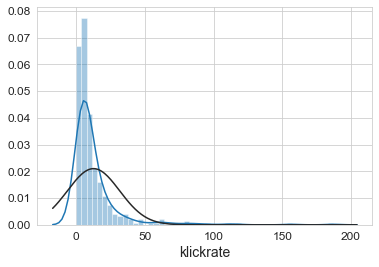

In [64]:
sns.distplot(df_train["klickrate"], fit=norm)

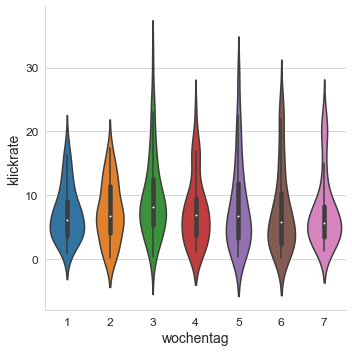

In [35]:
g = sns.catplot(data=df_train, x="wochentag", y="klickrate", kind="violin")

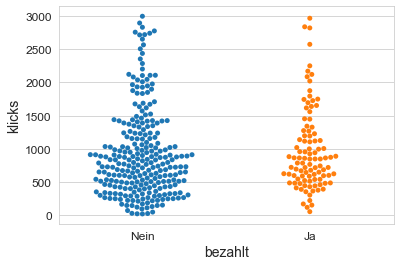

In [40]:
sns.swarmplot(data=df_train, x="bezahlt", y="klicks")

(array([334.,  44.,   8.,   6.,   3.,   2.,   1.,   0.,   1.,   1.]),
 array([1.44491966e-01, 1.88547841e+01, 3.75650763e+01, 5.62753684e+01,
        7.49856605e+01, 9.36959527e+01, 1.12406245e+02, 1.31116537e+02,
        1.49826829e+02, 1.68537121e+02, 1.87247413e+02]),
 <a list of 10 Patch objects>)

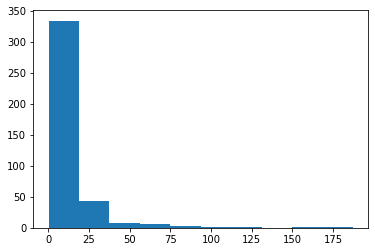

In [12]:
plt.hist(df_train["klickrate"])

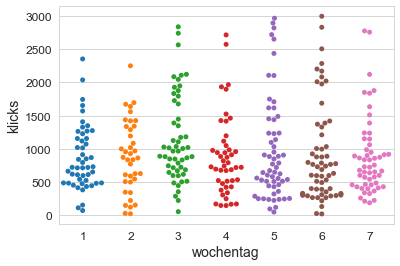

In [41]:
sns.swarmplot(data=df_train, x="wochentag", y="klicks")

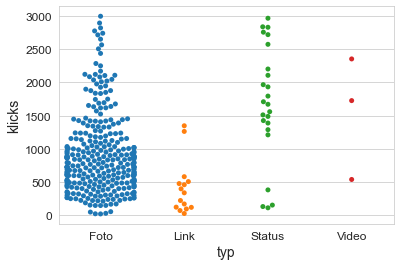

In [38]:
sns.swarmplot(data=df_train, x="typ", y="klicks")

# Modellierung

Start with the most random model of all: Predict zero (or mean of trainingsklicks for the test data). I will use a validation set from the training data set in the ratio of 80 20.

Zu erst definieren wir die Errormetrik:
$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} | y_{i} - \hat{y}_{i}|
$$

In [28]:
def mae(Y, Yhat):
    """Mean absolute error"""
    s = np.sum(np.abs(Y - Yhat))
    return np.mean(s)

In [42]:
mae(df_train["klicks"], 0)

338461.0

In [43]:
from sklearn.model_selection import train_test_split

In [51]:
def model(df):
    X, y = df.iloc[:, 0:5], df.iloc[:, 6]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    y_hat = 0
    

In [52]:
model(df_train)

(     wochentag  stunde   likes     typ kategorie
 3            7      12  131953    Foto   Produkt
 18           4       3  124940    Foto   Produkt
 202          2       4  137021    Foto    Aktion
 250          2      15  104069  Status    Aktion
 274          3      15  115894    Foto   Produkt
 ..         ...     ...     ...     ...       ...
 71           4      10  137175    Foto   Produkt
 106          3       6  129599    Foto    Aktion
 270          3      12   91650    Foto    Aktion
 348          7      10  133681    Foto   Produkt
 102          4       2   81369    Foto    Aktion
 
 [320 rows x 5 columns],
      wochentag  stunde   likes   typ    kategorie
 209          7       3  138188  Foto       Aktion
 280          7      13  129602  Foto       Aktion
 33           1      10  133679  Foto  Inspiration
 210          5       4  135712  Foto       Aktion
 93           2       3  139441  Foto      Produkt
 ..         ...     ...     ...   ...          ...
 246          6 